# Predicting Vaccination: Modeling H1N1

Analysis by Corey Hanson & Frank Flavell

![](img/pred_vacc_model_h1n1.png)

## Table of Contents<span id="0"></span>

1. [**Train/ Test Split, Class Imbalance & Standardization**](#1)
    * User Defined Function for splitting, standardizing and correcting class imbalance
    * Train/test set relabeling
2. [**Logisitic Regression**](#2)
    * Baseline
    * Optimized Models
3. [**K-Nearest Neighbor**](#3)
    * Baseline
    * Determine Best K
    * Optimized Model
4. [**Decision Tree**](#4)
    * Baseline
    * Determine Best Depth
    * Optimized Model
5. [**Random Forest**](#5)
    * Baseline
    * GridSearch
    * Optimized Model
6. [**AdaBoost**](#6)
    * Baseline
    * GridSearch
    * Optimized Model
7. [**XGBoost**](#7)
    * Baseline
    * GridSearch
    * Optimized Models
8. [**Support Vector Machine**](#8)
    * Baseline
    * GridSearch
    * Optimized Models
9. [**Best Model**](#9)
    * Analysis
    * Recommendations
    

# Package Import

In [177]:
!pip install imblearn
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import TomekLinks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from cleaning_functions import *
from eda import *
from sklearn.model_selection import cross_val_score
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *
from sklearn.preprocessing import StandardScaler

# Data Import and Review

In [145]:
df = pd.read_pickle('data.pickle')

In [146]:
pd.set_option('display.max_columns', None)
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,homeowner,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,1.0,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,0.0,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,Above Poverty,Not Married,1.0,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,1,1,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,0.0,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,unknown,unknown,0,1,0,1,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,Above Poverty,Married,1.0,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,0,1,0,0,0,0


In [147]:
df.shape

(26707, 43)

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 43 columns):
h1n1_concern                   26707 non-null float64
h1n1_knowledge                 26707 non-null float64
behavioral_antiviral_meds      26707 non-null float64
behavioral_avoidance           26707 non-null float64
behavioral_face_mask           26707 non-null float64
behavioral_wash_hands          26707 non-null float64
behavioral_large_gatherings    26707 non-null float64
behavioral_outside_home        26707 non-null float64
behavioral_touch_face          26707 non-null float64
doctor_recc_h1n1               26707 non-null float64
doctor_recc_seasonal           26707 non-null float64
chronic_med_condition          26707 non-null float64
child_under_6_months           26707 non-null float64
health_worker                  26707 non-null float64
health_insurance               26707 non-null float64
opinion_h1n1_vacc_effective    26707 non-null float64
opinion_h1n1_risk          

In [149]:
df.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,homeowner,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000
mean,1.619800,1.261392,0.048714,0.727749,0.068933,0.825888,0.357472,0.336279,0.678811,0.202494,0.303067,0.272962,0.080054,0.108548,0.934998,3.852810,2.337589,2.352380,4.025536,2.705321,2.115737,0.777998,0.887558,0.529599,0.212454,0.465608,0.080878,0.459580,0.076459,0.009323,0.026398,0.065114
std,0.909016,0.617047,0.215273,0.445127,0.253345,0.379213,0.479264,0.472444,0.466942,0.401866,0.459592,0.445490,0.271382,0.311077,0.246533,1.000195,1.276825,1.353339,1.077131,1.375216,1.319585,0.415600,0.749980,0.925264,0.409052,0.498825,0.272652,0.498373,0.265737,0.096108,0.160318,0.246732
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,4.000000,5.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# <span id="1"></span>1. Train/ Test Split, Class Imbalance & Standardization
#### [Return Contents](#0)
<hr/>

During EDA, we determined that there was a class imblance for the H1N1 Vaccination target variable.  To correct this imbalance, we downsampled the majority class so that our models would run faster during training.

The user-defined class below creates an object, 'data', that houses the original dataframe as well as any transformations we added including dummy variables, scaling, class imbalance correction and ploynomial features.  It also takes care of the train/test split.

In [150]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.
binary_columns = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'homeowner']
missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"
target_cols = [target_col1, target_col2]
untr = ['household_adults', 'household_children',]
nom = df.columns.drop([*untr, *binary_columns, *target_cols, *missing_dummies])

#The dicts that come into the arguments.
categorical = {
    "nominal_features":nom, "standard_dummies": binary_columns, "impute_dummies":missing_dummies
}

continuous = {"untransformed":untr}
polynomial = {"method":"choose", "columns":['age_group', 'education', 'sex',
                                            'doctor_recc_seasonal', 'income_poverty']}

In [151]:
data = DataPreprocessor(df, target_col1, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class='downsample', scale_type=False, poly_degree=2)
data.column_drop(data.cols_polynomial)
data.column_drop(['doctor_recc_seasonal education_Some College',
                  'doctor_recc_seasonal sex_Male'], reverse=True)
data.get_df()


Creating Dummies
Getting polynomial features of degree 2
Performing downsample
No scaling specified
Skipping scaling
Adding ['doctor_recc_seasonal^2', 'doctor_recc_seasonal age_group_35 - 44 Years', 'doctor_recc_seasonal age_group_45 - 54 Years', 'doctor_recc_seasonal age_group_55 - 64 Years', 'doctor_recc_seasonal age_group_65+ Years', 'doctor_recc_seasonal education_< 12 Years', 'doctor_recc_seasonal education_College Graduate', 'doctor_recc_seasonal education_Some College', 'doctor_recc_seasonal sex_Male', 'doctor_recc_seasonal income_poverty_Above Poverty', 'doctor_recc_seasonal income_poverty_Below Poverty', 'doctor_recc_seasonal income_poverty_unknown', 'age_group_35 - 44 Years^2', 'age_group_35 - 44 Years age_group_45 - 54 Years', 'age_group_35 - 44 Years age_group_55 - 64 Years', 'age_group_35 - 44 Years age_group_65+ Years', 'age_group_35 - 44 Years education_< 12 Years', 'age_group_35 - 44 Years education_College Graduate', 'age_group_35 - 44 Years education_Some College', 'a

,household_adults,household_children,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,homeowner,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,opinion_h1n1_vacc_effective_2.0,opinion_h1n1_vacc_effective_3.0,opinion_h1n1_vacc_effective_4.0,opinion_h1n1_vacc_effective_5.0,opinion_h1n1_risk_2.0,opinion_h1n1_risk_3.0,opinion_h1n1_risk_4.0,opinion_h1n1_risk_5.0,opinion_h1n1_sick_from_vacc_2.0,opinion_h1n1_sick_from_vacc_3.0,opinion_h1n1_sick_from_vacc_4.0,opinion_h1n1_sick_from_vacc_5.0,opinion_seas_vacc_effective_2.0,opinion_seas_vacc_effective_3.0,opinion_seas_vacc_effective_4.0,opinion_seas_vacc_effective_5.0,opinion_seas_risk_2.0,opinion_seas_risk_3.0,opinion_seas_risk_4.0,opinion_seas_risk_5.0,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male,income_poverty_Above Poverty,income_poverty_Below Poverty,income_poverty_unknown,marital_status_Not Married,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_unknown,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,doctor_recc_seasonal education_Some College,doctor_recc_seasonal sex_Male,h1n1_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12299,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1
8759,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

In [152]:
data.df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,homeowner,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,1.0,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,0.0,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,Above Poverty,Not Married,1.0,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0,1,1,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,0.0,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,unknown,unknown,0,1,0,1,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,Above Poverty,Married,1.0,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,Above Poverty,Not Married,1.0,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,unknown,unknown,0,0,0,1,0,0,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,Above Poverty,Not Married,0.0,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0,0,0,0,0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,unknown,Not Married,1.0,Employed,lzgpxyit,"MSA, Not Principle City",0.0,0.0,unknown,unknown,0,1,0,1,0,0,0,1


## Train/ Test Set Labeling

DataFrame with the dummy variables and the downsample class imblanace correction.

In [153]:
df2 = data.get_df()

In [154]:
X_train_reg = data.get_X_train()
y_train_reg = data.y_train

X_test_reg = data.get_X_test()
y_test_reg = data.y_test

# X_train_sel_reg = X_train.loc[:,select_features]
# y_train_sel_reg = y_train

# X_test_sel_reg = X_test.loc[:,select_features]
# y_test_sel_reg = y_test

In [155]:
target = 'h1n1_vaccine'

reg_features = df2.columns.drop('h1n1_vaccine')

scaled_features = extract_column_names(df2, "_scaled$")

select_features = ['doctor_recc_h1n1', 'opinion_h1n1_vacc_effective_5.0', 'missing_health_insurance', 'opinion_h1n1_risk_4.0', 'opinion_h1n1_risk_5.0', 'household_adults', 'health_worker', 'marital_status_Not Married']

select_features_scaled = ['doctor_recc_h1n1_scaled', 'opinion_h1n1_vacc_effective_5.0_scaled', 'missing_health_insurance_scaled', 'opinion_h1n1_risk_4.0_scaled', 'opinion_h1n1_risk_5.0_scaled', 'household_adults_scaled', 'health_worker_scaled', 'marital_status_Not Married_scaled']


In [156]:
df2.head()

,household_adults,household_children,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,homeowner,missing_doctor_recc,missing_health_insurance,missing_homeowner,missing_household,missing_opinion,missing_demographics,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,opinion_h1n1_vacc_effective_2.0,opinion_h1n1_vacc_effective_3.0,opinion_h1n1_vacc_effective_4.0,opinion_h1n1_vacc_effective_5.0,opinion_h1n1_risk_2.0,opinion_h1n1_risk_3.0,opinion_h1n1_risk_4.0,opinion_h1n1_risk_5.0,opinion_h1n1_sick_from_vacc_2.0,opinion_h1n1_sick_from_vacc_3.0,opinion_h1n1_sick_from_vacc_4.0,opinion_h1n1_sick_from_vacc_5.0,opinion_seas_vacc_effective_2.0,opinion_seas_vacc_effective_3.0,opinion_seas_vacc_effective_4.0,opinion_seas_vacc_effective_5.0,opinion_seas_risk_2.0,opinion_seas_risk_3.0,opinion_seas_risk_4.0,opinion_seas_risk_5.0,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male,income_poverty_Above Poverty,income_poverty_Below Poverty,income_poverty_unknown,marital_status_Not Married,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_unknown,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,doctor_recc_seasonal education_Some College,doctor_recc_seasonal sex_Male,h1n1_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12299,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1
8759,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

# Standardization

In [157]:
scaler = StandardScaler()
subset_scaled = []
for var in reg_features:
    new_col = var +"_scaled"
    X_train_reg[new_col] = scaler.fit_transform(X_train_reg[[var]])
    X_test_reg[new_col] = scaler.transform(X_test_reg[[var]])
    subset_scaled.append(new_col)

In [158]:
X_train_scaled = X_train_reg[extract_column_names(X_train_reg, "_scaled$")]
y_train_scaled = y_train_reg

X_test_scaled = X_test_reg[extract_column_names(X_test_reg, "_scaled$")]
y_test_scaled = y_test_reg

In [159]:
full_df = pd.concat([X_train_reg, X_test_reg], axis=0)

In [160]:
full_y = pd.concat([y_train_reg, y_test_reg], axis=0)

# Selected Features

In [161]:
X_train_sel_reg = X_train_reg[select_features]
y_train_sel_reg = y_train_reg

X_test_sel_reg = X_test_reg[select_features]
y_test_sel_reg = y_test_reg

X_train_sel_scaled = X_train_reg[select_features_scaled]
y_train_sel_scaled = y_train_reg

X_test_sel_scaled = X_test_reg[select_features_scaled]
y_test_sel_scaled = y_test_reg

# Instantiating the Evaluation DataFrame

In [165]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Accuracy':[],
                           'Precision':[],
                           'FP':[],
                           'Recall':[],
                           'FN':[],
                           'F1-Score':[],
                           'AUC':[]})

# <span id="2"></span>2. Logistic Regression
#### [Return Contents](#0)
<hr/>

# Logistic Regression Baseline

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report 
from sklearn import metrics

#---------------------------------------------------------------------------------------------

# Logisitic Regression 1: All Features, Not Scaled
logreg1 = LogisticRegression().fit(X_train_reg,y_train_reg)
y_pred1 = logreg1.predict(X_test_reg)

cm = metrics.confusion_matrix(y_test_reg, y_pred1)
print('Logisitic Regression 1: All Features, Not Scaled')
print('Confusion Matrix :')
print(cm)
print('Test Accuracy Score :',metrics.accuracy_score(y_test_reg, y_pred1))
print('Report : ')
print(classification_report(y_test_reg, y_pred1))

acc = float(format(metrics.accuracy_score(y_test_reg, y_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_reg, y_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_reg, y_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_reg, y_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_reg, y_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-1','all features, not scaled',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Logisitic Regression 1: All Features, Not Scaled
Confusion Matrix :
[[3432  826]
 [ 265  819]]
Test Accuracy Score : 0.7957693747660053
Report : 
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4258
           1       0.50      0.76      0.60      1084

    accuracy                           0.80      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.80      0.81      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.6


# Logistic Regression Optimizations

In [167]:
# Logisitic Regression 2: All Features, Scaled
logreg2 = LogisticRegression().fit(X_train_scaled,y_train_scaled)
y_pred2 = logreg2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred2)
print('Logisitic Regression 2: All Features, Scaled')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred2))
print('Report : ')
print(classification_report(y_test_scaled, y_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-2','all features, scaled',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

#---------------------------------------------------------------------------------------------

#Logistic Regression 3: Select Features, Not Scaled
logreg3 = LogisticRegression().fit(X_train_sel_reg,y_train_sel_reg)
y_pred3 = logreg3.predict(X_test_sel_reg)

cm = metrics.confusion_matrix(y_test_scaled, y_pred3)
print('Logisitic Regression 3: Select Features, Not Scaled')
print('Confusion Matrix :')
print(cm)
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred3))
print('Report : ')
print(classification_report(y_test_scaled, y_pred3))

acc = float(format(metrics.accuracy_score(y_test_reg, y_pred3, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_reg, y_pred3),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_reg, y_pred3),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_reg, y_pred3),'.3f'))
f1 = float(format(metrics.f1_score(y_test_reg, y_pred3),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-3','select features, not scaled',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled
logreg4 = LogisticRegression().fit(X_train_sel_scaled,y_train_sel_scaled)
y_pred4 = logreg4.predict(X_test_sel_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred4)
print('Logisitic Regression 4: Select Features, Scaled')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred4))
print('Report : ')
print(classification_report(y_test_scaled, y_pred4))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred4, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred4),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred4),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred4),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred4),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-4','select features, scaled',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled, Poly Degree 2
from sklearn.preprocessing import PolynomialFeatures
polyfeat = PolynomialFeatures(degree=2)
X_trainpoly = polyfeat.fit_transform(X_train_sel_scaled)
X_testpoly = polyfeat.fit_transform(X_test_sel_scaled)
logreg5 = LogisticRegression().fit(X_trainpoly,y_train_sel_scaled)
y_pred5 = logreg5.predict(X_testpoly)

cm = metrics.confusion_matrix(y_test_scaled, y_pred5)
print('Logisitic Regression 5: Select Features, Scaled, Poly 2')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred5))
print('Report : ')
print(classification_report(y_test_scaled, y_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred5, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred5),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred5),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred5),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred5),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-5','select features, scaled, poly 2',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

#---------------------------------------------------------------------------------------------

#Logistic Regression: Select Features, Scaled, Poly Degree 3
polyfeat = PolynomialFeatures(degree=3)
X_trainpoly = polyfeat.fit_transform(X_train_sel_scaled)
X_testpoly = polyfeat.fit_transform(X_test_sel_scaled)
logreg6 = LogisticRegression().fit(X_trainpoly,y_train_sel_scaled)
y_pred6 = logreg6.predict(X_testpoly)

cm = metrics.confusion_matrix(y_test_scaled, y_pred6)
print('Logisitic Regression 5: Select Features, Scaled, Poly 3')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred6))
print('Report : ')
print(classification_report(y_test_scaled, y_pred6))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred6, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred6),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred6),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred6),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred6),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Logistic Regression-6','select features, scaled, poly 3',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Logisitic Regression 2: All Features, Scaled
Confusion Matrix :
[[3432  826]
 [ 264  820]]
Test Accuracy Score : 0.7959565705728192
Report : 
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4258
           1       0.50      0.76      0.60      1084

    accuracy                           0.80      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.80      0.81      5342

Logisitic Regression 3: Select Features, Not Scaled
Confusion Matrix :
[[3357  901]
 [ 281  803]]
Test Accuracy Score : 0.7787345563459378
Report : 
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      4258
           1       0.47      0.74      0.58      1084

    accuracy                           0.78      5342
   macro avg       0.70      0.76      0.71      5342
weighted avg       0.83      0.78      0.79      5342

Logisitic Regression 4: Select Features, Scaled
Confusi

,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568
4,Logistic Regression-5,"select features, scaled, poly 2",0.759,0.446,1047.0,0.777,242.0,0.765,0.566


# <span id="3"></span>3. K-Nearest Neighbor (K-NN)
#### [Return Contents](#0)
<hr/>

# Baseline K-NN

In [168]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
# Instantiate KNeighborsClassifier
knn1 = KNeighborsClassifier()
# Fit the classifier
knn1.fit(X_train_scaled, y_train_scaled)
# Predict on the test set
y_pred_knn1 = knn1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred_knn1)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred_knn1))
print('Report : ')
print(classification_report(y_test_scaled, y_pred_knn1))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred_knn1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred_knn1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred_knn1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred_knn1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred_knn1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['K-Nearest Neighbor','baseline K=1',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2875 1383]
 [ 369  715]]
Test Accuracy Score : 0.6720329464619993
Report : 
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      4258
           1       0.34      0.66      0.45      1084

    accuracy                           0.67      5342
   macro avg       0.61      0.67      0.61      5342
weighted avg       0.78      0.67      0.70      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568
4,Logistic Regression-5,"select features, scaled, poly 2",0.759,0.446,1047.0,0.777,242.0,0.765,0.566
6,K-Nearest Neighbor,baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


# KNN Optimization

In [169]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = metrics.f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [170]:
find_best_k(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, min_k=1, max_k=11)

Best Value for k: 9
F1-Score: 0.47028423772609823


In [171]:
# search for an optimal value of K for KNN
k_range = list(range(1, 11))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_scaled)
    y_predict = knn.predict(X_test_scaled)
    score = metrics.f1_score(y_test_scaled, y_predict, average='weighted')
    k_scores.append(score)
print(k_scores)

[0.6557597159964801, 0.7507862336410064, 0.6932952855612802, 0.7532837166402875, 0.7021245055091099, 0.7494712766400834, 0.7156547495731275, 0.7483425710451154, 0.7202365132357981, 0.7465399674537562]


# KNN Optimized, K = 9

In [172]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
# Instantiate KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=9)
# Fit the classifier
knn2.fit(X_train_scaled, y_train_scaled)
# Predict on the test set
y_pred_knn2 = knn2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred_knn2)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred_knn2))
print('Report : ')
print(classification_report(y_test_scaled, y_pred_knn2))

acc = float(format(metrics.accuracy_score(y_test_scaled, y_pred_knn2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, y_pred_knn2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, y_pred_knn2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, y_pred_knn2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, y_pred_knn2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['K-Nearest Neighbor','Optimized K=XXX',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2974 1284]
 [ 356  728]]
Test Accuracy Score : 0.6929988768251591
Report : 
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      4258
           1       0.36      0.67      0.47      1084

    accuracy                           0.69      5342
   macro avg       0.63      0.69      0.63      5342
weighted avg       0.79      0.69      0.72      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568
4,Logistic Regression-5,"select features, scaled, poly 2",0.759,0.446,1047.0,0.777,242.0,0.765,0.566
7,K-Nearest Neighbor,Optimized K=XXX,0.693,0.362,1284.0,0.672,356.0,0.685,0.470
6,K-Nearest Neighbor,baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


# <span id="4"></span>4. Decision Tree
#### [Return Contents](#0)
<hr/>

# Decision Tree Baseline

In [173]:
# Instantiate and fit a DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dt1 = DecisionTreeClassifier(criterion='gini')

# fit the model
dt1.fit(X_train_scaled, y_train_scaled)
dt_pred1 = dt1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, dt_pred1)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, dt_pred1))
print('Report : ')
print(classification_report(y_test_scaled, dt_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, dt_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, dt_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, dt_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, dt_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, dt_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree-1','Baseline',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[2821 1437]
 [ 294  790]]
Test Accuracy Score : 0.6759640584050918
Report : 
              precision    recall  f1-score   support

           0       0.91      0.66      0.77      4258
           1       0.35      0.73      0.48      1084

    accuracy                           0.68      5342
   macro avg       0.63      0.70      0.62      5342
weighted avg       0.79      0.68      0.71      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568
4,Logistic Regression-5,"select features, scaled, poly 2",0.759,0.446,1047.0,0.777,242.0,0.765,0.566
8,Decision Tree-1,Baseline,0.676,0.355,1437.0,0.729,294.0,0.696,0.477
7,K-Nearest Neighbor,Optimized K=XXX,0.693,0.362,1284.0,0.672,356.0,0.685,0.470
6,K-Nearest Neighbor,baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


# Determine Feature Importance

In [174]:
# Feature importance
importance = pd.DataFrame(dt1.feature_importances_, index=X_train_scaled.columns).reset_index().sort_values(by = 0, ascending=False)
importance.head(8).values

array([['doctor_recc_h1n1_scaled', 0.16969860861804767],
       ['opinion_h1n1_vacc_effective_5.0_scaled', 0.061120026142828895],
       ['missing_health_insurance_scaled', 0.05092901460582436],
       ['opinion_h1n1_risk_4.0_scaled', 0.02826580345443882],
       ['health_worker_scaled', 0.018410624651850324],
       ['opinion_h1n1_risk_5.0_scaled', 0.017719606412031148],
       ['household_adults_scaled', 0.01729114676966324],
       ['household_children_scaled', 0.014951441181393256]], dtype=object)

In [175]:
['doctor_recc_h1n1_scaled', 'opinion_h1n1_vacc_effective_5.0_scaled', 'missing_health_insurance_scaled', 'opinion_h1n1_risk_4.0_scaled', 'opinion_h1n1_risk_5.0_scaled', 'household_adults_scaled', 'health_worker_scaled', 'marital_status_Not Married_scaled']

['doctor_recc_h1n1_scaled',
 'opinion_h1n1_vacc_effective_5.0_scaled',
 'missing_health_insurance_scaled',
 'opinion_h1n1_risk_4.0_scaled',
 'opinion_h1n1_risk_5.0_scaled',
 'household_adults_scaled',
 'health_worker_scaled',
 'marital_status_Not Married_scaled']

In [225]:
def show_feature_importances(model, df, figsize=(14, 12), palette=None, font_scale=1, ascending=False, rows=12, style="darkgrid"):
    sns.set_style(style)
    f, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=font_scale)
    importance = pd.DataFrame(model.feature_importances_, index=df.columns).reset_index()
    importance.columns = pd.Index(["Feature", "Importance"])
    sns.barplot(y="Feature", x="Importance", data=importance.sort_values("Importance",ascending=ascending).iloc[0:rows],
                palette=palette, ax=ax)

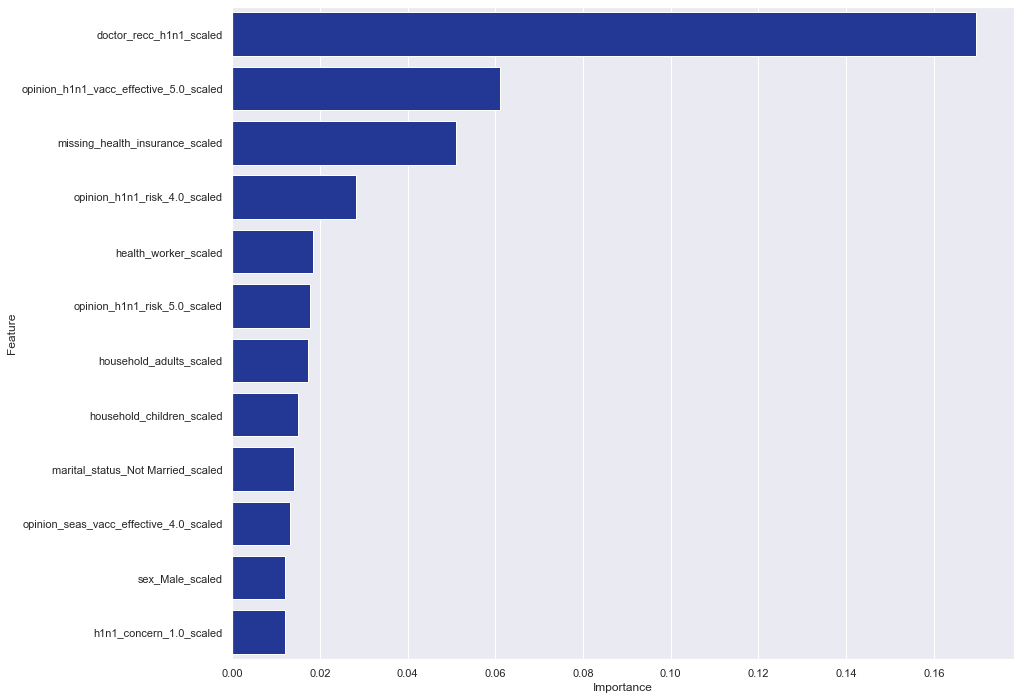

In [226]:
# Feature importance Graph
pal = sns.color_palette(("#102CA8",))
show_feature_importances(dt1, X_train_scaled, figsize=(14, 12), palette=pal, font_scale=1, ascending=False, rows=12, style="darkgrid")


# Determine Ideal Depth

[0.6920479302832245, 0.7235294117647058, 0.7441176470588234, 0.7555555555555556, 0.7584967320261439, 0.7630718954248366, 0.7590413943355121, 0.7552287581699347, 0.7546840958605665]


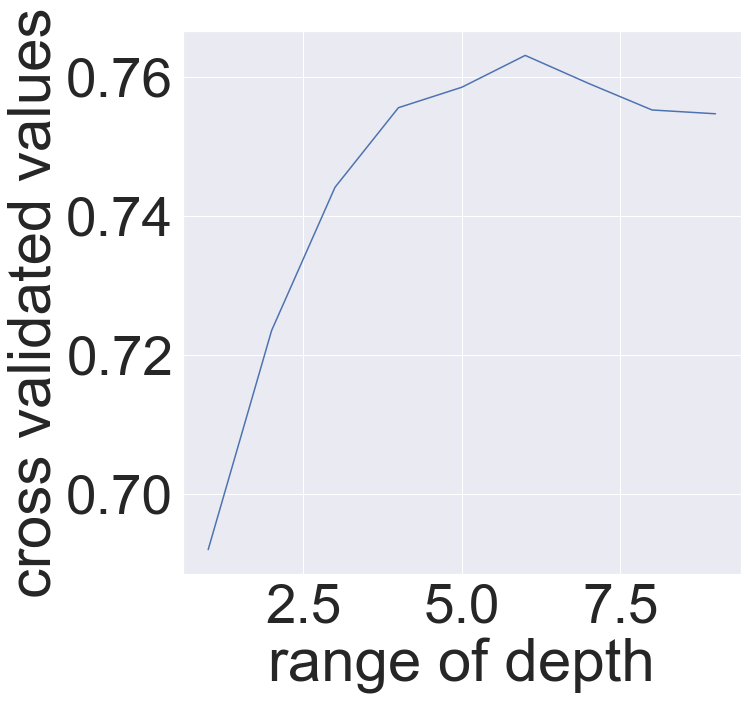

In [179]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(dt1, X_train_reg, y_train_reg, cv = 5)
score.mean()
depth_range = range(1,10)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, X_train_reg, y_train_reg, cv = 5)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

# Optimized Decision Tree: Depth 6

In [180]:
# Instantiate and fit a DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=6)

# fit the model
dt2.fit(X_train_scaled, y_train_scaled)
dt_pred2 = dt2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, dt_pred2)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, dt_pred2))
print('Report : ')
print(classification_report(y_test_scaled, dt_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, dt_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, dt_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, dt_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, dt_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, dt_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree-2','Optimized: Depth 6',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[3327  931]
 [ 274  810]]
Test Accuracy Score : 0.7744290527892175
Report : 
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4258
           1       0.47      0.75      0.57      1084

    accuracy                           0.77      5342
   macro avg       0.69      0.76      0.71      5342
weighted avg       0.83      0.77      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568
4,Logistic Regression-5,"select features, scaled, poly 2",0.759,0.446,1047.0,0.777,242.0,0.765,0.566
8,Decision Tree-1,Baseline,0.676,0.355,1437.0,0.729,294.0,0.696,0.477
7,K-Nearest Neighbor,Optimized K=XXX,0.693,0.362,1284.0,0.672,356.0,0.685,0.470
6,K-Nearest Neighbor,baseline K=1,0.672,0.341,1383.0,0.660,369.0,0.667,0.449


# Decision Tree: Depth 6 with Poly Features Degree 3

In [181]:
from sklearn.preprocessing import PolynomialFeatures
polyfeat = PolynomialFeatures(degree=3)
X_trainpoly = polyfeat.fit_transform(X_train_sel_scaled)
X_testpoly = polyfeat.fit_transform(X_test_sel_scaled)

from sklearn.tree import DecisionTreeClassifier
dt3 = DecisionTreeClassifier(criterion='gini', max_depth=6)

# fit the model
dt3.fit(X_trainpoly, y_train_scaled)
# Predictions
dt_pred3 = dt3.predict(X_testpoly)

cm = metrics.confusion_matrix(y_test_scaled, dt_pred3)
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, dt_pred3))
print('Report : ')
print(classification_report(y_test_scaled, dt_pred3))

acc = float(format(metrics.accuracy_score(y_test_scaled, dt_pred3, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, dt_pred3),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, dt_pred3),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, dt_pred3),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, dt_pred3),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Decision Tree-3','Depth 6, Poly Degree 3',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[3450  808]
 [ 311  773]]
Test Accuracy Score : 0.7905278921752152
Report : 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4258
           1       0.49      0.71      0.58      1084

    accuracy                           0.79      5342
   macro avg       0.70      0.76      0.72      5342
weighted avg       0.83      0.79      0.80      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568
4,Logistic Regression-5,"select features, scaled, poly 2",0.759,0.446,1047.0,0.777,242.0,0.765,0.566
8,Decision Tree-1,Baseline,0.676,0.355,1437.0,0.729,294.0,0.696,0.477
7,K-Nearest Neighbor,Optimized K=XXX,0.693,0.362,1284.0,0.672,356.0,0.685,0.470


# <span id="5"></span>5. Random Forest
#### [Return Contents](#0)
<hr/>

# Baseline Random Forest

In [182]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
forest1 = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest1.fit(X_train_scaled, y_train_scaled)
forest_pred1 = forest1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, forest_pred1)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, forest_pred1))
print('Report : ')
print(classification_report(y_test_scaled, forest_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, forest_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, forest_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, forest_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, forest_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, forest_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Random Forest-1','100 est, max depth 5',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)


Confusion Matrix :
[[3342  916]
 [ 274  810]]
Accuracy Score : 0.7772369898914264
Report : 
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4258
           1       0.47      0.75      0.58      1084

    accuracy                           0.78      5342
   macro avg       0.70      0.77      0.71      5342
weighted avg       0.83      0.78      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
11,Random Forest-1,"100 est, max depth 5",0.777,0.469,916.0,0.747,274.0,0.766,0.577
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568
4,Logistic Regression-5,"select features, scaled, poly 2",0.759,0.446,1047.0,0.777,242.0,0.765,0.566
8,Decision Tree-1,Baseline,0.676,0.355,1437.0,0.729,294.0,0.696,0.477


# Random Forest Optimization: GridSearch

In [183]:
param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [ 2, 5, 10],
    'min_samples_leaf': [2, 3, 5, 7]
}

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#Instantiate the gridsearch object
rf_grid_search = GridSearchCV(forest1, param_grid, cv=3)

# Fit to the data
rf_grid_search.fit(X_train_reg, y_train_reg)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

# Optimized Random Forest

In [184]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
forest2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False)
forest2.fit(X_train_scaled, y_train_scaled)
forest_pred2 = forest1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, forest_pred2)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, forest_pred2))
print('Report : ')
print(classification_report(y_test_scaled, forest_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, forest_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, forest_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, forest_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, forest_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, forest_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Random Forest-2','Optimized Hyperparameters',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[3342  916]
 [ 274  810]]
Accuracy Score : 0.7772369898914264
Report : 
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4258
           1       0.47      0.75      0.58      1084

    accuracy                           0.78      5342
   macro avg       0.70      0.77      0.71      5342
weighted avg       0.83      0.78      0.79      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
11,Random Forest-1,"100 est, max depth 5",0.777,0.469,916.0,0.747,274.0,0.766,0.577
12,Random Forest-2,Optimized Hyperparameters,0.777,0.469,916.0,0.747,274.0,0.766,0.577
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568
4,Logistic Regression-5,"select features, scaled, poly 2",0.759,0.446,1047.0,0.777,242.0,0.765,0.566


# <span id="6"></span>6. AdaBoost
#### [Return Contents](#0)
<hr/>

# AdaBoost Baseline

In [185]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)
ada1 = adaboost_clf.fit(X_train_scaled, y_train_scaled)
ada_pred1 = ada1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, ada_pred1)
print('Confusion Matrix :')
print(cm)
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, ada_pred1))
print('Report : ')
print(classification_report(y_test_scaled, ada_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, ada_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, ada_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, ada_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, ada_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, ada_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['AdaBoost-1','Baseline',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)


Confusion Matrix :
[[3413  845]
 [ 267  817]]
Accuracy Score : 0.7918382628229128
Report : 
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4258
           1       0.49      0.75      0.60      1084

    accuracy                           0.79      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.79      0.81      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
13,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
11,Random Forest-1,"100 est, max depth 5",0.777,0.469,916.0,0.747,274.0,0.766,0.577
12,Random Forest-2,Optimized Hyperparameters,0.777,0.469,916.0,0.747,274.0,0.766,0.577
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573
5,Logistic Regression-6,"select features, scaled, poly 3",0.760,0.448,1039.0,0.777,242.0,0.766,0.568


# AdaBoost Optimization: GridSearch

In [189]:
param_grid = {
    "learning_rate": [0.1, 0.2],
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=5)],
    'n_estimators': [5, 30, 100, 250],
}

ada_clf = AdaBoostClassifier(random_state=42)
grid_ada = GridSearchCV(ada_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_ada.fit(X_train_scaled, y_train_scaled)

best_parameters = grid_ada.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_ada.predict(X_train_scaled)
val_preds = grid_ada.predict(X_test_scaled)
training_accuracy = accuracy_score(y_train_scaled, training_preds)
val_accuracy = accuracy_score(y_test_scaled, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
base_estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
learning_rate: 0.2
n_estimators: 250

Training Accuracy: 78.16%
Validation accuracy: 79.5%


# AdaBoost Optimized

In [192]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), learning_rate=0.2, n_estimators=250, random_state=42)
ada2 = adaboost_clf.fit(X_train_scaled, y_train_scaled)
ada_pred2 = ada2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, ada_pred2)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, ada_pred2))
print('Report : ')
print(classification_report(y_test_scaled, ada_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, ada_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, ada_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, ada_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, ada_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, ada_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['AdaBoost-2','Optimized',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[3429  829]
 [ 266  818]]
Accuracy Score : 0.7950205915387495
Report : 
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4258
           1       0.50      0.75      0.60      1084

    accuracy                           0.80      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.80      0.81      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
14,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
13,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
11,Random Forest-1,"100 est, max depth 5",0.777,0.469,916.0,0.747,274.0,0.766,0.577
12,Random Forest-2,Optimized Hyperparameters,0.777,0.469,916.0,0.747,274.0,0.766,0.577
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
9,Decision Tree-2,Optimized: Depth 6,0.774,0.465,931.0,0.747,274.0,0.764,0.573


# <span id="7"></span>7. XGBoost
#### [Return Contents](#0)
<hr/>

# XGBoost Baseline

In [193]:
X_train_scaled = X_train_scaled.rename(columns=lambda x: x.replace('<', '_'))

In [194]:
X_test_scaled = X_test_scaled.rename(columns=lambda x: x.replace('<', '_'))

In [195]:
import xgboost as xgb
clf1 = xgb.XGBClassifier()
clf1.fit(X_train_scaled, y_train_scaled)
xgb_pred1 = clf1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, xgb_pred1)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, xgb_pred1))
print('Report : ')
print(classification_report(y_test_scaled, xgb_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, xgb_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, xgb_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, xgb_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, xgb_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, xgb_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['XGBoosting-1','Baseline',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[3413  845]
 [ 261  823]]
Accuracy Score : 0.7929614376637963
Report : 
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4258
           1       0.49      0.76      0.60      1084

    accuracy                           0.79      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.79      0.81      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
14,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
15,XGBoosting-1,Baseline,0.793,0.493,845.0,0.759,261.0,0.780,0.598
13,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
11,Random Forest-1,"100 est, max depth 5",0.777,0.469,916.0,0.747,274.0,0.766,0.577
12,Random Forest-2,Optimized Hyperparameters,0.777,0.469,916.0,0.747,274.0,0.766,0.577
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576


# XGBoost Optimization: GridSearch

In [ ]:
param_grid = {'n_estimators':[100,300,500],
              'learning_rate':[0.1,0.5,0.01],
              'max_depth':[3,5,7],
              'colsample_bytree':[0.5,0.4,0.3],
              'min_child_weight':[1,2,3]
             }

clf_xg = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf_xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_scaled, y_train_scaled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_scaled)
val_preds = grid_clf.predict(X_test_scaled)
training_accuracy = accuracy_score(y_train_scaled, training_preds)
val_accuracy = accuracy_score(y_test_scaled, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

# XGBoost Optimized

In [202]:
clf2 = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=500, min_child_weight=2, colsample_bytree=0.5)
clf2.fit(X_train_scaled, y_train_scaled)
xgb_pred2 = clf2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, xgb_pred2)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, xgb_pred2))
print('Report : ')
print(classification_report(y_test_scaled, xgb_pred2))

acc = float(format(metrics.accuracy_score(y_test_scaled, xgb_pred2, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, xgb_pred2),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, xgb_pred2),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, xgb_pred2),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, xgb_pred2),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['XGBoosting-2','Optimized',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[3350  908]
 [ 258  826]]
Accuracy Score : 0.7817296892549607
Report : 
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      4258
           1       0.48      0.76      0.59      1084

    accuracy                           0.78      5342
   macro avg       0.70      0.77      0.72      5342
weighted avg       0.84      0.78      0.80      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
14,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
15,XGBoosting-1,Baseline,0.793,0.493,845.0,0.759,261.0,0.780,0.598
13,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
16,XGBoosting-2,Optimized,0.782,0.476,908.0,0.762,258.0,0.774,0.586
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
11,Random Forest-1,"100 est, max depth 5",0.777,0.469,916.0,0.747,274.0,0.766,0.577
12,Random Forest-2,Optimized Hyperparameters,0.777,0.469,916.0,0.747,274.0,0.766,0.577
3,Logistic Regression-4,"select features, scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576


# <span id="8"></span>8. Support Vector Machine
#### [Return Contents](#0)
<hr/>

# Support Vector Machine Baseline

In [203]:
from sklearn.svm import SVC  
svc1 = SVC(kernel='poly', C=.01)  
svc1.fit(X_train_scaled, y_train_scaled) 
svc_pred1 = svc1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, svc_pred1)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, svc_pred1))
print('Report : ')
print(classification_report(y_test_scaled, svc_pred1))

acc = float(format(metrics.accuracy_score(y_test_scaled, svc_pred1, sample_weight=None), '.3f'))
prec = float(format(metrics.precision_score(y_test_scaled, svc_pred1),'.3f'))
fp = cm[0,1]
rec = float(format(metrics.recall_score(y_test_scaled, svc_pred1),'.3f'))
fn = cm[1,0]
auc = float(format(metrics.roc_auc_score(y_test_scaled, svc_pred1),'.3f'))
f1 = float(format(metrics.f1_score(y_test_scaled, svc_pred1),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['SVM','poly, c=.01',acc,prec,fp,rec,fn,auc,f1]
evaluation.sort_values(by = 'AUC', ascending=False)

Confusion Matrix :
[[4243   15]
 [1063   21]]
Accuracy Score : 0.7982029202545863
Report : 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4258
           1       0.58      0.02      0.04      1084

    accuracy                           0.80      5342
   macro avg       0.69      0.51      0.46      5342
weighted avg       0.76      0.80      0.71      5342



,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
14,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
15,XGBoosting-1,Baseline,0.793,0.493,845.0,0.759,261.0,0.780,0.598
13,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
16,XGBoosting-2,Optimized,0.782,0.476,908.0,0.762,258.0,0.774,0.586
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
11,Random Forest-1,"100 est, max depth 5",0.777,0.469,916.0,0.747,274.0,0.766,0.577
12,Random Forest-2,Optimized Hyperparameters,0.777,0.469,916.0,0.747,274.0,0.766,0.577
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576


# <span id="9"></span>9. Best Model
#### [Return Contents](#0)
<hr/>

Based on Accuracy and Area Under the Curve (AUC), our best model appears to be Logistic Regression with an accuracy of .796, a harmonic F1-Score of .781 and an Area Under the Curve of .601.

However, it is important to note that this model is very tolerant in terms of the number of false positives with a precision rate of .498 and a total of 826 false positives on the test set.  The model prioritizes false negatives with a recall of .756 and a total of 264 false negatives on the test set.

**Fasle Positives** = predicted that people did vaccinate when they didn't.

**False Negatives** = predicted that people did not vaccinate when they actually did.

This model may not be the best depending on the organizations goals.  For example, if this model is used to achieve a goal like maximizing the number of vaccinations in the population, then you may want a model that minimizes the false positives, meaning that there would be a low tolerance for predicting that someone did vaccinate when they actually did not (false positive) and higher tolerance for predicting that someone did not vaccinate when they actually did (false negative).

If this is the case, then the Support Vector Machine actully achieved a higher accuracy even though it performed the worst on the AUC metric.  Compared to the Logisitic Regression model, SVM only allowed 15 false positives but with a greater tadeoff of false negatives for a total of 1,063 on the test set.  The low C value of 0.01 means the SVM model is less tolerant of the violation, which in turn gives us a more complex model with a higher variance and a lower bias.

On the other hand, if the organizations goals is to minimize resource allocation for a direct mail marketing campaign designed to increase awareness for vaccinations, then the organization may prefer to use the Logisitic Regression model which won't predict everyone who did not vaccinate, but at least the campaign would reach the people who matter most, like the elderly. 

In [205]:
evaluation.sort_values(by = 'AUC', ascending=False)

,Model,Details,Accuracy,Precision,FP,Recall,FN,F1-Score,AUC
1,Logistic Regression-2,"all features, scaled",0.796,0.498,826.0,0.756,264.0,0.781,0.601
0,Logistic Regression-1,"all features, not scaled",0.796,0.498,826.0,0.756,265.0,0.781,0.600
14,AdaBoost-2,Optimized,0.795,0.497,829.0,0.755,266.0,0.780,0.599
15,XGBoosting-1,Baseline,0.793,0.493,845.0,0.759,261.0,0.780,0.598
13,AdaBoost-1,Baseline,0.792,0.492,845.0,0.754,267.0,0.778,0.595
16,XGBoosting-2,Optimized,0.782,0.476,908.0,0.762,258.0,0.774,0.586
10,Decision Tree-3,"Depth 6, Poly Degree 3",0.791,0.489,808.0,0.713,311.0,0.762,0.580
11,Random Forest-1,"100 est, max depth 5",0.777,0.469,916.0,0.747,274.0,0.766,0.577
12,Random Forest-2,Optimized Hyperparameters,0.777,0.469,916.0,0.747,274.0,0.766,0.577
2,Logistic Regression-3,"select features, not scaled",0.779,0.471,901.0,0.741,281.0,0.765,0.576


### Logistic Regression Model Analysis

In [207]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib
def confusion_matrix_graph(model, X_test, y_test, font_scale=2, style="darkgrid", palette=None, figsize=(14, 12)):
    sns.set_style(style)
    sns.set(font_scale=font_scale)
    f, ax = plt.subplots(figsize=figsize)
    converted_pal = matplotlib.colors.ListedColormap(sns.color_palette(palette))
    plot_confusion_matrix(model, X_test, y_test, cmap=converted_pal, ax=ax)
    for text in ax.texts:
        label = text.get_text()
        label = int(float(label))
        text.set_text(f"{label}")
    plt.show()

Logisitic Regression 2: All Features, Scaled
Confusion Matrix :
[[3432  826]
 [ 264  820]]
Test Accuracy Score : 0.7959565705728192
Report : 
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4258
           1       0.50      0.76      0.60      1084

    accuracy                           0.80      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.84      0.80      0.81      5342



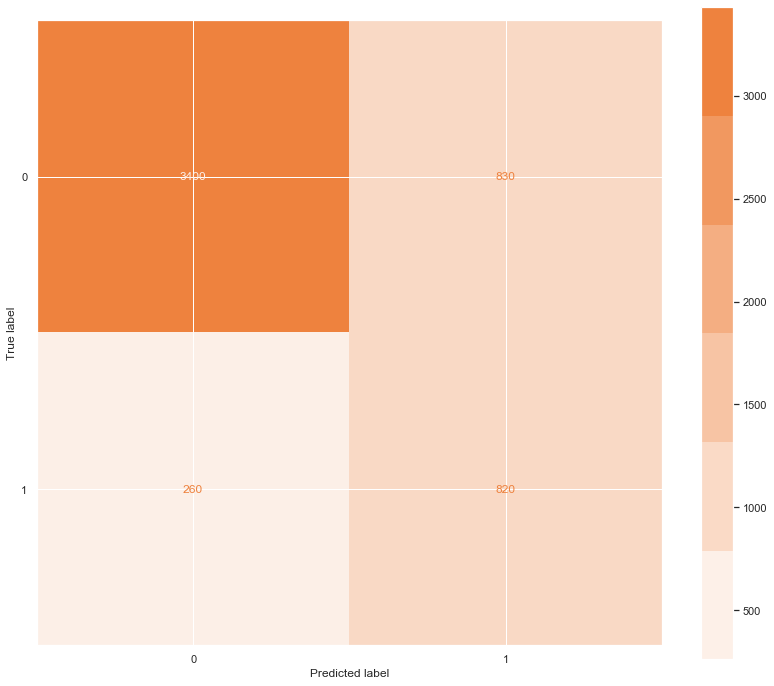

In [219]:
# Logisitic Regression 2: All Features, Scaled
logreg2 = LogisticRegression().fit(X_train_scaled,y_train_scaled)
y_pred2 = logreg2.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, y_pred2)
print('Logisitic Regression 2: All Features, Scaled')
print('Confusion Matrix :')
print(cm) 
print('Test Accuracy Score :',metrics.accuracy_score(y_test_scaled, y_pred2))
print('Report : ')
print(classification_report(y_test_scaled, y_pred2))

palette = sns.light_palette("#EE823E")
confusion_matrix_graph(logreg2, X_test_scaled, y_test_scaled, font_scale=1, palette=palette, figsize=(14,12))

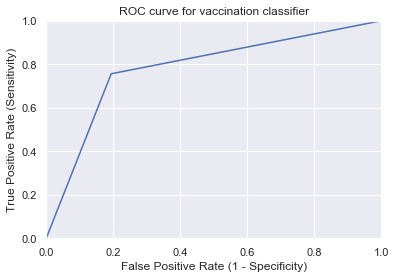

In [223]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test_scaled, y_pred2)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for vaccination classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Support Vector Machine Model Analysis

Confusion Matrix :
[[4243   15]
 [1063   21]]
Accuracy Score : 0.7982029202545863
Report : 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4258
           1       0.58      0.02      0.04      1084

    accuracy                           0.80      5342
   macro avg       0.69      0.51      0.46      5342
weighted avg       0.76      0.80      0.71      5342



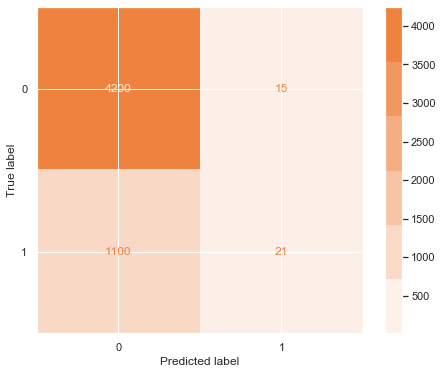

In [227]:
from sklearn.svm import SVC  
svc1 = SVC(kernel='poly', C=.01)  
svc1.fit(X_train_scaled, y_train_scaled) 
svc_pred1 = svc1.predict(X_test_scaled)

cm = metrics.confusion_matrix(y_test_scaled, svc_pred1)
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',metrics.accuracy_score(y_test_scaled, svc_pred1))
print('Report : ')
print(classification_report(y_test_scaled, svc_pred1))

palette = sns.light_palette("#EE823E")
confusion_matrix_graph(svc1, X_test_scaled, y_test_scaled, font_scale=1, palette=palette, figsize=(8,6))

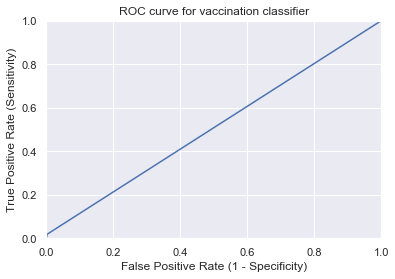

In [224]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test_scaled, svc_pred1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for vaccination classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Recommendations